In [ ]:
# Mount Google Drive (if your data is stored there; skip this if using local files)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Set the working directory (update the path based on your environment)
# If using Google Colab with Google Drive, specify the correct path; otherwise, use a local path.
os.chdir('/content/drive/MyDrive/Project_VTTI')  # Example for Google Colab
# os.chdir('/path/to/your/local/directory')  # Uncomment and replace for local usage

In [ ]:
# Importing the necessary libraries and functions! 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
import os

# Function that aggregates all the csv files from both folders into two dataframes for identified and unknown
def aggregate_csvs(directory_path):
    # set up an Empty list
    dataframes = []

    # Going through directories to concatenate it all (all the CSV's)
    for subdir, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.csv'):
                filepath = os.path.join(subdir, file)
                df = pd.read_csv(filepath)
                dataframes.append(df)

    # Combine all DataFrames into one
    aggregated_df = pd.concat(dataframes, ignore_index=True)
    return aggregated_df

identified_data = aggregate_csvs('Identified_Classifier') # target folder, identified_classifier is a split datasets
unknown_data = aggregate_csvs('Unknown_Classifier')# unknown_classifier is a split dataset



# The actual important features we want to try out.
def important_features(sigF):

    window_size_milliseconds_steering = 10000  # 10 seconds window of time
    window_size_milliseconds_distance = 1000  # 1 second window of time


    # Wheel positions features
    sigF['steering_stability'] = sigF['vtti.steering_wheel_position'].rolling(window=window_size_milliseconds_steering).std()

    # Pedal features
    sigF['brake_duration'] = sigF.groupby((sigF['vtti.pedal_brake_state'] != sigF['vtti.pedal_brake_state'].shift()).cumsum()).cumcount() * sigF['vtti.pedal_brake_state']
    sigF['brake_event'] = sigF['vtti.pedal_brake_state'].diff().apply(lambda x: 1 if x == 1 else 0) #  Brake event important!
    sigF['brake_frequency'] = sigF['brake_event'].rolling(window=window_size_milliseconds_steering).sum()


    # Lateral Position
    sigF['avg_abs_distance_from_center'] = sigF['vtti.lane_distance_off_center'].abs().rolling(window=window_size_milliseconds_distance).mean()
    sigF['lateral_velocity'] = sigF['vtti.lane_distance_off_center'].diff()
    sigF['lateral_acceleration'] = sigF['lateral_velocity'].diff()




    return sigF

identified_data_MLP = important_features(identified_data) # New dataframe with only the significant features included!
unknown_data_MLP = important_features(unknown_data)       # Same thing was the line above!



# Our significant features (the ones we defined earlier)
#significant_columns = ['steering_stability','brake_duration','brake_frequency',
                      #'avg_abs_distance_from_center','lateral_velocity','lateral_acceleration']

# New sig features

significant_columns = ['lateral_velocity','brake_frequency',
                       'avg_abs_distance_from_center','lateral_acceleration']   # WORKs

identified_data_MLP = identified_data_MLP[significant_columns] # Code that makes the dataframe shorter based on the features we want to keep
unknown_data_MLP = unknown_data_MLP[significant_columns] # Does same thing as line above

In [ ]:
identified_data_MLP.dropna(inplace=True) #Drop Null values
unknown_data_MLP.dropna(inplace=True)

<ipython-input-4-72119c45dfb2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_data_MLP.dropna(inplace=True) #Drop Null values
<ipython-input-4-72119c45dfb2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data_MLP.dropna(inplace=True)


In [ ]:
print(identified_data_MLP.shape) # Make sure the shape is healthy
print(unknown_data_MLP.shape)

(1022486, 4)
(1069361, 4)


In [ ]:
print(identified_data_MLP[['lateral_velocity','brake_frequency',
                       'avg_abs_distance_from_center','lateral_acceleration']].isna().sum()) # CHECK NULL VALUES FOR IDENTIFIED DATASET BEFORE PROCEEDING

lateral_velocity                0
brake_frequency                 0
avg_abs_distance_from_center    0
lateral_acceleration            0
dtype: int64


In [ ]:
print(unknown_data_MLP[['lateral_velocity','brake_frequency',
                       'avg_abs_distance_from_center','lateral_acceleration']].isna().sum()) # CHECK NULL VALUES FOR UNKNOWN DATASET BEFORE PROCEEDING

lateral_velocity                0
brake_frequency                 0
avg_abs_distance_from_center    0
lateral_acceleration            0
dtype: int64


In [ ]:
print(identified_data_MLP[0:100]) # Check healthy Shape for identified data

       lateral_velocity  brake_frequency  avg_abs_distance_from_center  \
15038          0.000000             58.0                    124.497663   
15039          0.000000             58.0                    124.490494   
15040          0.000000             58.0                    124.488096   
15041          0.000000             58.0                    124.485699   
15042          0.000000             58.0                    124.483301   
...                 ...              ...                           ...   
15133          0.000000             58.0                    118.997795   
15134          0.000000             58.0                    118.890905   
15135         73.443410             58.0                    118.917091   
15136         38.161072             58.0                    118.922848   
15137         -0.677319             58.0                    118.927674   

       lateral_acceleration  
15038              0.000000  
15039              0.000000  
15040              0.

In [ ]:
print(unknown_data_MLP[0:100000]) # Check healthy Shape for unknown data

        lateral_velocity  brake_frequency  avg_abs_distance_from_center  \
10433           0.000000              1.0                      8.499999   
10434           0.000000              1.0                      8.499999   
10435           0.000000              1.0                      8.499999   
10436           0.000000              1.0                      8.499999   
10437           0.000000              1.0                      8.499999   
...                  ...              ...                           ...   
294583          3.894670              0.0                     30.364727   
294584          4.233342              0.0                     30.392145   
294585         -1.550535              0.0                     30.418520   
294586          9.001236              0.0                     30.452966   
294587         11.937995              0.0                     30.500365   

        lateral_acceleration  
10433               0.000000  
10434               0.000000  
10435 

In [ ]:
# First part of the cell looks similar to the other ones (subset of scikit-learn)
import joblib
from sklearn.preprocessing import StandardScaler

# To avoid unnecessary warnings, create copies!

identified_data_MLP = identified_data_MLP.copy()
unknown_data_MLP = unknown_data_MLP.copy()

# Combining the datasets + creating a target variable for each class

identified_data_MLP.loc[:,'target'] = 1
unknown_data_MLP.loc[:,'target'] = 0
combined_data_MLP = pd.concat([identified_data_MLP, unknown_data_MLP], ignore_index=True)

# Handle missing values
#combined_data_SVM.fillna(0, inplace=True)

# Splitting the data
X = combined_data_MLP.drop('target', axis=1)
y = combined_data_MLP['target']

from sklearn.model_selection import train_test_split

X_train_MLP, X_test_MLP, y_train_MLP, y_test_MLP = train_test_split(X, y, test_size=0.2, random_state=5)

# Scaler (needed for better performance, important step but not necessarilly needed)
sc = StandardScaler()

# Fit the scaler using the training data and transform the training data
X_train_MLP_sc = sc.fit_transform(X_train_MLP)

# Transform the test data using the same scaler
X_test_MLP_sc = sc.transform(X_test_MLP)

# Save X_test_SVM and y_test_SVM
joblib.dump(X_test_MLP_sc, 'X_test_MLP_sc.pkl')
joblib.dump(y_test_MLP, 'y_test_MLP.pkl')

['y_test_MLP.pkl']

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report # Classification report + accuracy score

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, activation='relu', random_state=5) # Training the MLP classifier
mlp.fit(X_train_MLP_sc, y_train_MLP) # Parameters are subjective, you have to find the best combination.

y_pred_train_MLP = mlp.predict(X_train_MLP_sc) # notice, we're using the scaled sets
y_pred_test_MLP = mlp.predict(X_test_MLP_sc)

print("Training Accuracy is:", accuracy_score(y_train_MLP, y_pred_train_MLP))
print("Test Accuracy is:", accuracy_score(y_test_MLP, y_pred_test_MLP))
print("\nClassification Report for Test Data:\n", classification_report(y_test_MLP, y_pred_test_MLP)) # Printing the classification report, standard stuff


Training Accuracy is: 0.7162649979653142
Test Accuracy is: 0.7157563878863207

Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73    213700
           1       0.72      0.68      0.70    204670

    accuracy                           0.72    418370
   macro avg       0.72      0.71      0.71    418370
weighted avg       0.72      0.72      0.72    418370



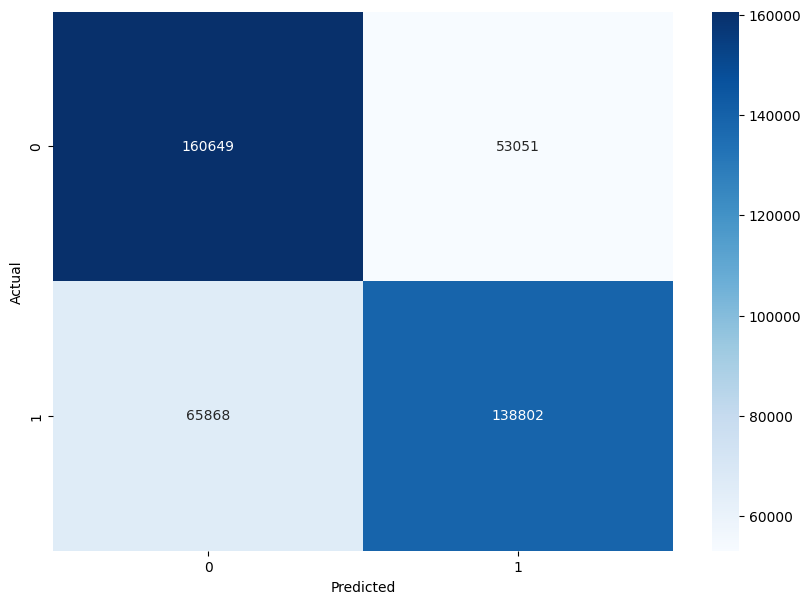

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # Importing all the necessary Libraries
import seaborn as sns

conf_matrix = confusion_matrix(y_test_MLP, y_pred_test_MLP) # Confusion matrix

plt.figure(figsize=(10,7)) # Standard size and color, change as you want
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() # Displaying the matrix

In [ ]:
from sklearn.model_selection import RandomizedSearchCV # HYPERTUNING PROCESS
from sklearn.metrics import accuracy_score, classification_report # Classification report + accuracy score
from sklearn.neural_network import MLPClassifier

# Define a searchable parameter space (based on your computational ressources!)
param_dist = {
    'hidden_layer_sizes': [(50,), (100,)],  # these are few options, can include much more!
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Sampling a subset of the data (in this case 30% which is standard), you can adjust as needed
from sklearn.model_selection import train_test_split
X_subset, _, y_subset, _ = train_test_split(X_train_MLP_sc, y_train_MLP, train_size=0.3, stratify=y_train_MLP)

# Initializing the MLP Classifier with 1000 max iter. Random state is arbiratry
mlp = MLPClassifier(max_iter=1000, random_state=5)

# Initialize RandomizedSearchCV (can include much more parameters and higher folds etc)
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=10, cv=3,
                                   scoring='accuracy', n_jobs=-1, verbose=2, random_state=5)

# Fitting te model on that subset (30% in this case)
random_search.fit(X_subset, y_subset)

# Print the best parameters (If you want to see and save them)
print("Best parameters found: ", random_search.best_params_)
best_mlp = random_search.best_estimator_

# Training the best model model on the full training set
best_mlp.fit(X_train_MLP_sc, y_train_MLP)

# Make predictions using the best model!
y_pred_train_MLP = best_mlp.predict(X_train_MLP_sc)
y_pred_test_MLP = best_mlp.predict(X_test_MLP_sc)

# Classification metrics (accuracy etc)
print("Training Accuracy is:", accuracy_score(y_train_MLP, y_pred_train_MLP))
print("Test Accuracy is:", accuracy_score(y_test_MLP, y_pred_test_MLP))
print("\nClassification Report for Test Data:\n", classification_report(y_test_MLP, y_pred_test_MLP))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.001, 'activation': 'relu'}
Training Accuracy is: 0.717887966192544
Test Accuracy is: 0.7175394985300093

Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74    213700
           1       0.74      0.65      0.69    204670

    accuracy                           0.72    418370
   macro avg       0.72      0.72      0.72    418370
weighted avg       0.72      0.72      0.72    418370



In [ ]:
import joblib # Only run if you want to save the model to your directory (to be deployed somewhere else or something)

joblib.dump(mlp,'MLP_model.pkl')

['MLP_model.pkl']

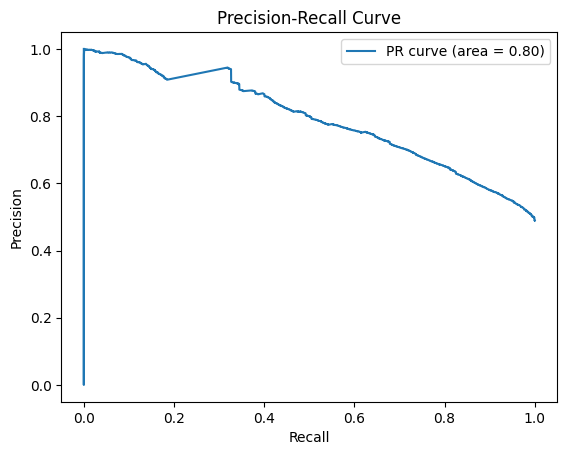

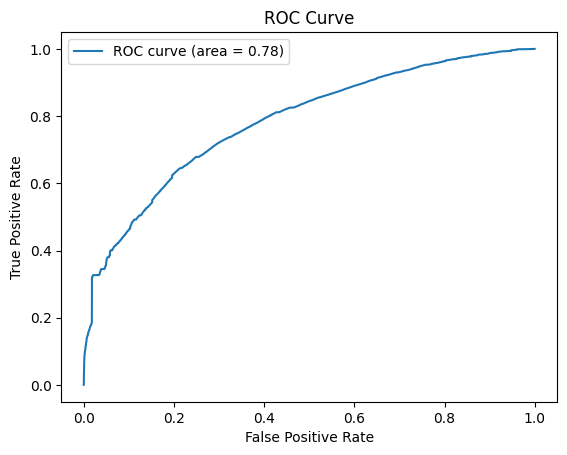

Log Loss: 0.5554697505761831
Cohen's Kappa is: 0.4304943170822805
Matthews Correlation Coefficient is: 0.43130758405857883


In [ ]:
import joblib # No real need to re-import, but just in case one does not want to rerun all the cells for some reason.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, log_loss, cohen_kappa_score, matthews_corrcoef

# Load the final model
MLP_model = joblib.load('MLP_model.pkl')

# Make sure X_test and y_test are loaded; check previous cells and rerun if neeeded. Code is there to make sure they are saved.

y_prob_MLP = MLP_model.predict_proba(X_test_MLP_sc)[:, 1]
y_pred_MLP = MLP_model.predict(X_test_MLP_sc)

# Plotting the Precision Curve (PRC)
precision, recall, _ = precision_recall_curve(y_test_MLP, y_prob_MLP)
average_precision = average_precision_score(y_test_MLP, y_prob_MLP)

plt.figure()
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# PLotting the ROC Curve and AUC
fpr_MLP, tpr_MLP, _ = roc_curve(y_test_MLP, y_prob_MLP)
roc_auc_MLP = auc(fpr_MLP, tpr_MLP)

plt.figure()
plt.plot(fpr_MLP, tpr_MLP, label='ROC curve (area = %0.2f)' % roc_auc_MLP)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Setting up the log loss
print("Log Loss:", log_loss(y_test_MLP, y_prob_MLP))

# Displaying the Cohen's Kappa metric (useful metric)
kappa_MLP = cohen_kappa_score(y_test_MLP, y_pred_MLP)
print("Cohen's Kappa is:", kappa_MLP)

# Displaying the Matthews Correlation Coefficient (useful metric)
mcc_MLP = matthews_corrcoef(y_test_MLP, y_pred_MLP)
print("Matthews Correlation Coefficient is:", mcc_MLP)